In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [2]:
df = pd.read_csv('~/Bureau/Datasets/TimeSeries/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


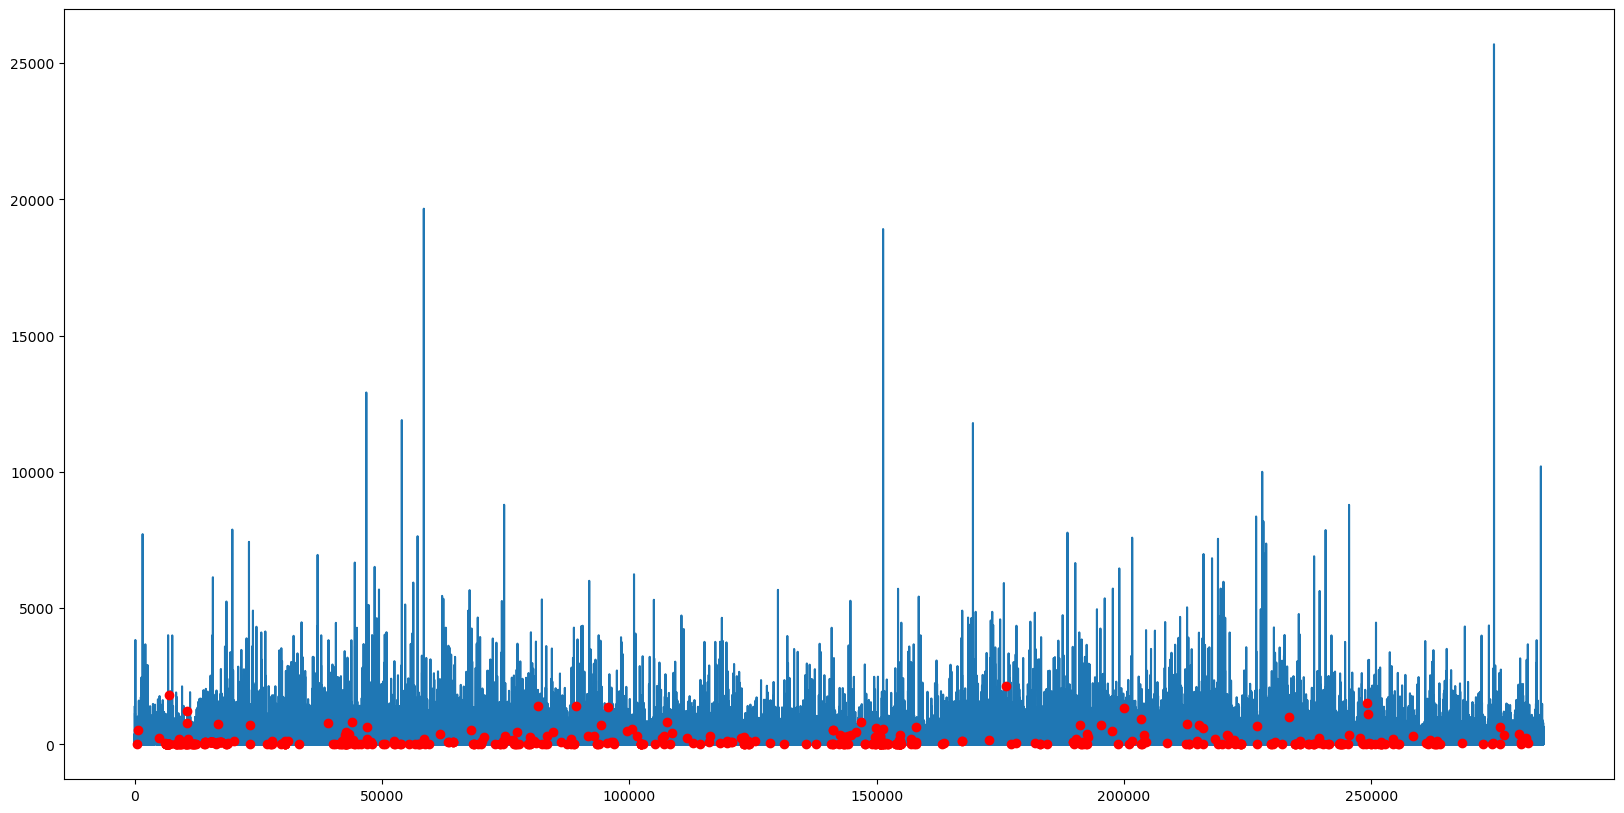

In [3]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value)
plt.plot( anomalies_indices, value[anomalies_indices], "ro")

In [4]:
# Number of transaction each second (respect of the time series)

df['transactions_seconds']=1

for i in range(1, len(df)):
    t = df.loc[i, 'Time']
    t1 = df.loc[i-1, 'Time']
    if t==t1:
        df.loc[i, 'transactions_seconds'] = df.loc[i-1, 'transactions_seconds'] + 1

In [214]:
train_size = int(0.6*len(df))

train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [215]:
scaler = StandardScaler()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

/tmp/ipykernel_23360/4053383572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
/tmp/ipykernel_23360/4053383572.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))


In [202]:
class ClassifDataset(nn.Module):
    def __init__(self, df):

        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        values = self.df.iloc[index].drop(['Time', 'Class'])
        target = self.df.loc[index, 'Class']

        return torch.Tensor(values.to_numpy()), torch.tensor(target)

In [ ]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()

        self.seq = nn.Sequential(
            nn.Linear(30, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.seq(x)

In [217]:
BATCH_SIZE=256
EPOCHS=2
LR=1e-3
DEVICE="cuda"

trainset = ClassifDataset(train)
testset = ClassifDataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True)

model = Classifier().to(DEVICE)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [218]:
pbar = range(EPOCHS)  # Outer progress bar for epochs

for epoch in pbar:
    epoch_loss = 0
    batch_pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS} Batches", leave=False)  # Inner progress bar for batches
    for inputs, targets in batch_pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        preds = model(inputs)
        preds = torch.squeeze(preds, dim=1)
        targets = targets.float()
        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Optionally update the inner pbar with the current loss
        batch_pbar.set_postfix(loss=loss.item())

    # Optionally update the outer pbar with the epoch loss
    print(f"epoch loss : {loss.item()/len(trainloader)}")

epoch loss : 7.155744852442406e-07


epoch loss : 1.793224017712996e-07


In [ ]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = model(test_batch).squeeze()
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:17<00:00, 25.73it/s]

ROC score: 0.9655059062294695
